# Analyse GSEA :

Le GEC permet de prédire la probabilité de survie de chaque patient après le diagnostic de sa maladie. Toutefois, il ne dévoile pas les mécanismes biologiques qui rendent certaines tumeurs plus agressives que d'autres. Pour approfondir cette question, nous rechercheront des signatures moléculaires associées aux tumeurs agressives identifiées par notre outil, en utilisant l'analyse GSEA (Gene Set Enrichment Analysis) du Broad Institute (Mootha et al. 2003 ; Subramanian et al. 2005). L'analyse GSEA est une méthode couramment employée par les biologistes. Elle permet d'explorer les signatures moléculaires déjà répertoriées dans la littérature et d'identifier celles qui sont significativement liées aux tumeurs exprimant plusieurs gènes spécifiques de tissus de manière ectopique.

Pour ce faire, nous allons utiliser les deux groupes extrèmes du GEC : 

Groupe GEC- (control, « GEC 0 ») = les échantillons pour lesquels GEC = 0

Groupe GEC+ (cas, « GEC 5-7 ») = les échantillons pour lesquels GEC = 5-7 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

Fonction de création du GEC : make_GEC

In [2]:
# genes retenus comme candidats pour le gec
biomarqueur = ['SPCS2P4','RNASE2','ESM1','HYAL3','HOMER1','CABLES2','MAGEA6']

def make_GEC(data, gene_biomarqueur, seuil_ectopy):
    """
    data :  expression data
    gene_biomarqueur : panel GEC des huit gènes candidats
    seuil_ectopy : thresholds calculated by "ectopy"
    """
   
    tab_GEC = {
        'id_sample': [],
        'SPCS2P4': [],
        'RNASE2': [],
        'ESM1': [],
        'HYAL3': [],
        'HOMER1': [],
        'CABLES2': [],
        'MAGEA6': [],
        'Gec': []
    }

    for i in range(1, data.shape[1]):
        id_sample = data.columns[i]
        tab_GEC['id_sample'].append(id_sample)
        num_active_genes = 0

        for gene in gene_biomarqueur:
            seuil = seuil_ectopy.loc[seuil_ectopy['Gene'] == gene, 'threshold_percentile'].values[0] / 100
            quantile_value = np.quantile(data.loc[data['gene_symbol'] == gene].iloc[:, 1:], seuil)
            gene_value = data.loc[data['gene_symbol'] == gene].iloc[:, i].astype(float)
            x = (gene_value > quantile_value).astype(int).values[0]
            num_active_genes += x
            tab_GEC[gene].append(x)
        
        tab_GEC['Gec'].append(num_active_genes)
        
    tab_GEC_df = pd.DataFrame(tab_GEC)

    return tab_GEC_df


Fonction pour calculer log2(fold change) : "rank"

In [5]:
# La fonction "rank" permet pour chaque groupe de calculer log2(fold change):

# log2(fold change) = (expression moyenne dans GEC+) - (expression moyenne dans GEC-)
#-------------------------------------------------------------------------------------------

def rank(expression_data, data_gec):
    """
    expression_data : données d'expression de gènes
    data_gec : données retournées par la fonction make_gec
    
    """
    ranks = []
    
    # Récupérer les échantillons dans les deux groupes
    sample_gec_0 = data_gec.loc[data_gec['Gec'] == 0, 'id_sample']
    sample_gec_5_7 = data_gec.loc[data_gec['Gec'].isin([5, 6, 7]), 'id_sample']
    
    # Calculer les rangs pour chaque ligne
    for i in range(expression_data.shape[0]):
        
        val_0 = expression_data.loc[i, sample_gec_0].astype(float)
        val_5_7 = expression_data.loc[i, sample_gec_5_7].astype(float)
        
        # Calculer la différence des moyennes
        rank_value = val_5_7.mean() - val_0.mean()
        ranks.append(rank_value)
    
    # Trier les rangs en ordre décroissant
    sorted_indices = np.argsort(ranks)[::-1]
    
    # Retourner un DataFrame avec les gènes triés et leurs rangs
    data_result = pd.DataFrame({
        'gene_symbol': expression_data['gene_symbol'].iloc[sorted_indices].values,
        'rank': np.array(ranks)[sorted_indices]
    })
    
    return data_result


Seuils calculés par "ectopy" :

In [4]:
# import data(ectopy_adaptaive_threshold_percentile)

seuil_ectopy = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/TRAINING_Ectopy_python_significant_genes_TCGA-LIHC_FDR_1.0.xlsx")
#seuil_ectopy = seuil_ectopy.iloc[1:].reset_index(drop=True)
print(seuil_ectopy.shape)
seuil_ectopy.head(3)

(58, 10)


,Gene,threshold_name,threshold,threshold_percentile,p_value,hazard_ratio,validated,cv_score,optimal,FDR
0,APLN,T63,1.431588,51.107239,0.003155,1.704304,True,14,True,0.011771
1,ASIC1,T26,0.482416,66.923592,0.023705,1.513679,True,2,True,0.051098
2,ATP6V1E2,T109,0.847760,74.107239,0.004508,1.715253,True,14,True,0.013664


With TCGA-LIHC dataset :

In [6]:
# import data 

# expression data
expression_data_TCGA_LIHC = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_tcga_lihc_TCGA-LIHC_log_fpkm_439_samples_43022_genes.csv", sep=";")

# clinic data
clinic_data_TCGA_LIHC = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_TCGA-LIHC.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# Sélection des échantillons tumoraux
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC[clinic_data_TCGA_LIHC['tissue_status'] == "tumoral"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_TCGA_LIHC['id_sample'].unique() if col in expression_data_TCGA_LIHC.columns]

# Sélection des données
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[['gene_symbol'] + selected_sample]

# Trouver les échantillons contenant des valeurs NaN dans expression_data_TCGA_LIHC
colonnes_avec_nan = expression_data_TCGA_LIHC.columns[expression_data_TCGA_LIHC.isna().any()].tolist()

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.dropna(axis=1) 
expression_data_TCGA_LIHC.head()

,gene_symbol,TCGA-G3-A3CG-01A,TCGA-DD-AAVP-01A,TCGA-FV-A3R3-01A,TCGA-G3-A25Y-01A,TCGA-DD-AADU-01A,TCGA-BC-A10S-01A,TCGA-5R-AA1D-01A,TCGA-G3-A25Z-01A,TCGA-DD-AAEH-01A,...,TCGA-DD-AAE0-01A,TCGA-FV-A4ZP-01A,TCGA-DD-A39V-01A,TCGA-DD-AAEK-01A,TCGA-DD-AAVX-01A,TCGA-DD-A11A-01A,TCGA-ZP-A9CY-01A,TCGA-BC-A10R-01A,TCGA-QA-A7B7-01A,TCGA-CC-5264-01A
0,A1BG,0.770871,0.040963,0.027437,0.091124,0.175557,0.504671,0.046421,1.051581,0.548042,...,0.151469,0.112367,0.164143,0.248535,0.263996,1.481041,0.658737,0.022900,1.262974,0.181929
1,A2M,9.506488,5.061577,9.857904,10.401114,3.414054,7.954206,9.001478,7.278122,8.891311,...,8.038818,7.227125,6.580620,8.759850,7.127064,6.459509,9.331142,9.116935,5.028834,6.211877
2,A2MP1,0.084200,0.011925,0.035202,0.091937,0.014498,0.066537,0.351854,0.042364,0.067088,...,0.033934,0.000000,0.126973,0.068189,0.063503,0.207393,0.431569,1.259965,0.118891,0.008774
3,NAT1,1.018064,1.085085,1.375457,0.663299,1.273576,1.354226,1.883738,1.913110,1.209890,...,0.434028,0.249021,0.748032,1.899678,1.996823,1.948638,2.011996,1.355918,1.577344,2.699174
4,NAT2,0.136191,2.611881,1.956466,0.050745,4.568683,2.579373,4.061085,3.426453,2.799688,...,0.896001,0.000000,1.285461,4.126915,2.814120,1.400811,4.996904,1.344885,1.266996,1.949647


In [8]:
# appel de la fonction make_gec pour le dataset TCGA_LIHC

data_gec_TCGA_LIHC = make_GEC(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
data_gec_TCGA_LIHC.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,TCGA-G3-A3CG-01A,1,0,0,0,0,0,0,1
1,TCGA-DD-AAVP-01A,0,1,1,1,0,1,0,4
2,TCGA-FV-A3R3-01A,0,0,0,0,0,0,0,0
3,TCGA-G3-A25Y-01A,1,1,0,1,0,1,0,4
4,TCGA-DD-AADU-01A,0,0,1,1,0,0,0,2


In [9]:
# appel de la fonction rank pour le dataset TCGA-LIHC

data_rank_TCGA_LIHC = rank(expression_data_TCGA_LIHC, data_gec_TCGA_LIHC)
data_rank_TCGA_LIHC.head()

,gene_symbol,rank
0,PEG10,3.138866
1,MAGEA3,2.891528
2,CDC20,2.821708
3,MYBL2,2.705026
4,MAGEA6,2.700015


In [10]:
# exporter en fichier rnk 

data_rank_TCGA_LIHC.to_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA/rank_TCGA_LIHC.rnk", sep="\t", index=False)

With GSE141202 dataset :

In [11]:
# expression data

expression_data_GSE141202 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE141202_log_rpkm_206_samples_38133_genes.csv", sep=";")

# clinic data
clinic_data_GSE141202 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.04.03_GSE141202.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
# Sélection des échantillons tumoraux
clinic_data_GSE141202 = clinic_data_GSE141202[clinic_data_GSE141202['tissue_status'] == "tumoral"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE141202['id_sample'].unique() if col in expression_data_GSE141202.columns]

# Sélection des données
expression_data_GSE141202 = expression_data_GSE141202[['gene_symbol'] + selected_sample]

In [13]:
# appel de la fonction make_gec pour le dataset GSE141202

data_gec_GSE141202 = make_GEC(expression_data_GSE141202, biomarqueur, seuil_ectopy)
data_gec_GSE141202.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,GSM4196911,0,0,0,1,0,0,0,1
1,GSM4196912,0,0,0,1,0,0,0,1
2,GSM4196913,1,0,0,1,0,1,1,4
3,GSM4196914,0,0,0,0,0,0,0,0
4,GSM4196915,0,0,0,1,0,1,1,3


In [14]:
# appel de la fonction rank pour le dataset GSE141202

data_rank_GSE141202 = rank(expression_data_GSE141202, data_gec_GSE141202)
data_rank_GSE141202.head()

,gene_symbol,rank
0,RNU1-70P,5.170336
1,COX3,4.917238
2,COX1,4.785883
3,ATP8,4.587871
4,RPL41P1,4.377263


In [15]:
# exporter en fichier rnk 

data_rank_GSE141202.to_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA/rank_GSE141202.rnk", sep="\t", index=False)

With GSE144269 dataset :

In [16]:
# expression data
expression_data_GSE144269 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE144269_log_rpkm_140_samples_31263_genes.csv", sep=";")


# clinic data
clinic_data_GSE144269 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_GSE144269.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [17]:
# Sélection des échantillons tumoraux
clinic_data_GSE144269 = clinic_data_GSE144269[clinic_data_GSE144269['tissue_status'] == "tumoral"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE144269['id_sample'].unique() if col in expression_data_GSE144269.columns]

# Sélection des données
expression_data_GSE144269 = expression_data_GSE144269[['gene_symbol'] + selected_sample]


expression_data_GSE144269.head()

,gene_symbol,GSM4284691,GSM4284737,GSM4284631,GSM4284671,GSM4284611,GSM4284717,GSM4284651,GSM4284711,GSM4284697,...,GSM4284739,GSM4284627,GSM4284733,GSM4284673,GSM4284667,GSM4284607,GSM4284653,GSM4284713,GSM4284693,GSM4284647
0,A1BG,6.072184,7.469392,5.892887,2.791881,1.081322,0.500986,7.681464,6.983162,8.581784,...,5.570586,6.309423,8.514211,7.369382,9.053515,3.544642,7.794161,8.881677,7.315939,2.707624
1,A2M,11.394621,7.260238,6.803496,5.321871,3.960193,7.214305,8.938084,5.292246,8.899177,...,10.267852,8.012846,4.752404,8.704495,8.285451,7.881444,5.172522,8.377472,10.133285,8.163660
2,A2MP1,0.176835,0.084593,0.739046,0.050764,0.000000,0.015573,0.096251,0.069038,0.064353,...,0.184180,0.016886,0.158624,0.069152,0.252845,0.170620,0.259233,0.485306,0.016654,0.338513
3,NAT1,1.231236,2.361237,1.742010,1.559337,1.087738,0.871096,1.191769,1.345833,2.386126,...,1.373437,1.876394,2.211605,2.125836,1.405851,1.036540,2.669538,1.718917,2.496492,0.831732
4,NAT2,0.216529,1.876400,1.456711,2.309803,0.050109,0.000000,1.230405,0.000000,3.660828,...,0.000000,1.321106,2.396213,4.184823,1.398019,0.319645,1.815908,2.394080,0.000000,0.206566


In [18]:
# appel de la fonction make_gec pour le dataset GSE144269

data_gec_GSE144269 = make_GEC(expression_data_GSE144269, biomarqueur, seuil_ectopy)
data_gec_GSE144269.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,GSM4284691,0,0,1,0,1,0,0,2
1,GSM4284737,0,1,0,1,0,1,0,3
2,GSM4284631,0,1,0,0,0,0,0,1
3,GSM4284671,0,1,1,1,0,1,0,4
4,GSM4284611,0,0,1,1,1,0,1,4


In [19]:
# appel de la fonction rank pour le dataset GSE144269

data_rank_GSE144269 = rank(expression_data_GSE144269, data_gec_GSE144269)
data_rank_GSE144269.head()

,gene_symbol,rank
0,H2AC18,6.602877
1,PEG10,5.379608
2,H3C2,5.209262
3,AKR1B10,5.039216
4,H2AC13,4.972373


In [20]:
# exporter en fichier rnk 

data_rank_GSE144269.to_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA/rank_GSE144269.rnk", sep="\t", index=False)

With GSE76427 dataset :

In [21]:
# dataset "GSE76427" 

expression_data_GSE76427 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE76427_GSE76427_log_expression_167_samples_30499_genes.csv", sep=";")

# clinic data
clinic_data_GSE76427 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.04.03_GSE76427.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [22]:
#clinic_data_GSE76427 = clinic_data_GSE76427.dropna(subset=['os_months', 'os_censor'])

# Sélection des échantillons tumoraux
clinic_data_GSE76427 = clinic_data_GSE76427[clinic_data_GSE76427['sample_source'] == "hepatocellular carcinoma tumor tissue"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE76427['id_sample'].unique() if col in expression_data_GSE76427.columns]

# Sélection des données
expression_data_GSE76427 = expression_data_GSE76427[['gene_symbol'] + selected_sample]

expression_data_GSE76427.head()

,gene_symbol,GSM2011285,GSM2011286,GSM2011287,GSM2011288,GSM2011289,GSM2011290,GSM2011291,GSM2011292,GSM2011293,...,GSM2011390,GSM2011391,GSM2011392,GSM2011393,GSM2011394,GSM2011395,GSM2011396,GSM2011397,GSM2011398,GSM2011399
0,A1BG,6.619120,7.011004,7.545196,7.019924,6.719183,7.523719,6.759555,6.758223,7.216455,...,6.780441,6.783980,6.876026,6.715482,6.870981,6.705287,6.965438,6.918386,7.204473,6.850249
1,A2M,12.365713,13.697642,13.794450,12.895821,11.875580,13.523074,12.978240,12.354175,11.952559,...,13.539663,14.053639,10.084742,12.266541,13.560415,13.390537,13.776348,0.000000,11.127620,12.715379
2,NAT1,6.989366,7.357904,7.188539,7.557425,7.476463,7.157650,7.214805,7.136684,7.182990,...,6.929554,6.996841,6.939579,7.293977,7.157751,7.052568,7.198396,7.521757,7.562624,7.178117
3,NAT2,8.555663,8.562357,9.078071,9.307884,9.191553,8.590886,9.011898,8.550131,9.073552,...,1.925999,0.000000,8.036778,8.894939,4.135863,10.146416,6.539004,10.194745,0.000000,10.799703
4,SERPINA3,14.692071,14.649701,14.995486,14.871793,13.604289,14.212165,15.059422,14.735338,13.071550,...,14.788332,14.805367,13.544037,14.837610,14.418967,14.951174,14.892597,13.164172,11.480679,14.900754


In [23]:
# appel de la fonction make_gec pour le dataset GSE76427

data_gec_GSE76427 = make_GEC(expression_data_GSE76427, biomarqueur, seuil_ectopy)
data_gec_GSE76427.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,GSM2011285,0,0,1,0,0,1,0,2
1,GSM2011286,0,0,0,1,0,0,1,2
2,GSM2011287,1,0,1,0,0,0,0,2
3,GSM2011288,0,0,0,1,0,0,1,2
4,GSM2011289,0,0,1,1,0,1,0,3


In [24]:
# appel de la fonction rank pour le dataset GSE76427

data_rank_GSE76427 = rank(expression_data_GSE76427, data_gec_GSE76427)
data_rank_GSE76427.head()

,gene_symbol,rank
0,GPR88,4.239910
1,XAGE1A,4.239576
2,VCX,4.168515
3,XAGE1C,4.135937
4,VCX3A,4.111871


In [25]:
# exporter en fichier rnk 

data_rank_GSE76427.to_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA/rank_GSE76427.rnk", sep="\t", index=False)

With GSE121248 dataset :

In [26]:
# dataset "GSE121248" 

expression_data_GSE121248 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE121248_GSE121248_log_expression_107_samples_21872_genes.csv", sep=";")

# clinic data
clinic_data_GSE121248 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_GSE121248.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [27]:
# Sélection des échantillons tumoraux
clinic_data_GSE121248 = clinic_data_GSE121248[clinic_data_GSE121248['sample_source'] == "Tumor sample from hepatocellular carcinoma patient"]

# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE121248['id_sample'].unique() if col in expression_data_GSE121248.columns]

# Sélection des données
expression_data_GSE121248 = expression_data_GSE121248[['gene_symbol'] + selected_sample]

expression_data_GSE121248.head()

,gene_symbol,GSM3428733,GSM3428770,GSM3428750,GSM3428730,GSM3428747,GSM3428727,GSM3428773,GSM3428753,GSM3428779,...,GSM3428762,GSM3428725,GSM3428745,GSM3428731,GSM3428751,GSM3428777,GSM3428774,GSM3428771,GSM3428734,GSM3428754
0,A1BG,13.145079,13.118273,13.215534,13.051060,11.021534,12.559943,12.291622,12.783900,12.537117,...,13.247361,13.161577,13.261560,13.110879,11.751025,13.789668,12.521671,12.516226,8.795688,11.910646
1,A2M,13.342202,12.725662,12.553407,13.502483,13.179525,13.263872,12.601803,10.950926,13.375806,...,12.380873,12.399291,13.628400,13.536591,12.903227,11.899765,12.680831,12.912727,12.766574,12.136907
2,A2MP1,5.162114,4.591075,5.396270,5.508598,4.734823,4.866892,5.486729,5.129093,4.680912,...,4.776731,5.250591,5.103338,5.022283,4.981959,5.553155,4.970691,5.374989,5.163157,5.024710
3,NAT1,7.715894,7.378908,8.770110,8.879047,6.644994,6.958841,7.229197,7.402302,7.804111,...,6.497482,9.003516,8.154285,8.104136,7.632132,8.718640,7.081439,6.172693,5.549184,8.122492
4,NAT2,7.343084,6.512738,7.905968,10.525658,5.633086,6.105676,6.644936,8.636656,7.568277,...,5.823022,7.738990,5.846448,8.973612,8.182548,9.845588,6.369902,6.630015,5.913346,5.977975


In [28]:
# appel de la fonction make_gec pour le dataset GSE121248

data_gec_GSE121248 = make_GEC(expression_data_GSE121248, biomarqueur, seuil_ectopy)
data_gec_GSE121248.head()

,id_sample,SPCS2P4,RNASE2,ESM1,HYAL3,HOMER1,CABLES2,MAGEA6,Gec
0,GSM3428733,0,1,0,0,0,1,0,2
1,GSM3428770,0,0,0,1,1,0,0,2
2,GSM3428750,0,0,1,0,0,0,0,1
3,GSM3428730,0,0,0,0,0,0,0,0
4,GSM3428747,0,0,1,0,1,1,0,3


In [29]:
# appel de la fonction rank pour le dataset GSE121248

data_rank_GSE121248 = rank(expression_data_GSE121248, data_gec_GSE121248)
data_rank_GSE121248.head()

,gene_symbol,rank
0,PEG10,6.756403
1,IGF2BP3,4.963587
2,RRM2,4.498261
3,TOP2A,4.106751
4,PBK,4.083052


In [30]:
# exporter en fichier rnk 

data_rank_GSE121248.to_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA/rank_GSE121248.rnk", sep="\t", index=False)

## Volcanoplot : 

In [31]:
# dataset TCGA-LIHC

# Test de Wilcoxon (Mann-Whitney)
#----------------------------------------------------------------------------------------------------

# Récupérer les échantillons dans les deux groupes
sample_gec_0 = data_gec_TCGA_LIHC.loc[data_gec_TCGA_LIHC['Gec'] == 0, 'id_sample']
sample_gec_5_7 = data_gec_TCGA_LIHC.loc[data_gec_TCGA_LIHC['Gec'].isin([5, 6, 7]), 'id_sample']

# p-valeurs du test de Mann-Whitney
p_vals = []

for i in range(expression_data_TCGA_LIHC.shape[0]):
    
    val_0 = expression_data_TCGA_LIHC.loc[i, sample_gec_0].astype(float)
    val_5_7 = expression_data_TCGA_LIHC.loc[i, sample_gec_5_7].astype(float)
   
    stat, p_value = mannwhitneyu(val_0, val_5_7, alternative='two-sided')
    p_vals.append(p_value)

# Trier les p-valeurs en ordre décroissant
sorted_indices = np.argsort(p_vals)[::-1]
    
# Retourner un DataFrame avec les gènes triés et leurs p-valeurs
diff_TCGA_LIHC = pd.DataFrame({
        'gene_symbol': expression_data_TCGA_LIHC['gene_symbol'].iloc[sorted_indices].values,
        'p_value': np.array(p_vals)[sorted_indices]
    })

In [32]:
diff_TCGA_LIHC.head()

,gene_symbol,p_value
0,OFD1P8Y,1.0
1,GLRX3P1,1.0
2,PHB1P2,1.0
3,KRT127P,1.0
4,LSM1P2,1.0


In [33]:
# fusionner les colonnes gene_symbol, rank(=diff_mean=log2(fold change)) et p-value(p-valeurs issues du test de Mann Whitneyy)
# dans un seul Dataframe

diff_TCGA_LIHC_bis = pd.merge(diff_TCGA_LIHC, data_rank_TCGA_LIHC, on='gene_symbol', how='inner')

diff_TCGA_LIHC_bis.head()

,gene_symbol,p_value,rank
0,OFD1P8Y,1.0,0.0
1,GLRX3P1,1.0,0.0
2,PHB1P2,1.0,0.0
3,KRT127P,1.0,0.0
4,LSM1P2,1.0,0.0


In [34]:
# Tri des p-values
diff_TCGA_LIHC_bis = diff_TCGA_LIHC_bis.sort_values(by="p_value")
diff_TCGA_LIHC_bis.head()

,gene_symbol,p_value,rank
43047,ESM1,9.343302e-12,1.873212
43046,TCF19,9.343302e-12,1.943673
43044,SGO2,1.092779e-11,1.051221
43045,CDCA8,1.092779e-11,2.118217
43043,CDK2,1.181590e-11,1.310227


In [35]:
diff_TCGA_LIHC_bis = diff_TCGA_LIHC_bis.reset_index()

In [36]:
# Calcul des p-valeurs ajustés (FDR)

pval_adj_diff_TCGA_LIHC_bis = multipletests(diff_TCGA_LIHC_bis['p_value'], method='fdr_bh')[1]

# ajout des p_vals ajustés dans le dataframe comme nouvelle colonne
diff_TCGA_LIHC_bis['pval_adj'] = pval_adj_diff_TCGA_LIHC_bis
diff_TCGA_LIHC_bis.head()

,index,gene_symbol,p_value,rank,pval_adj
0,43047,ESM1,9.343302e-12,1.873212,2.828426e-08
1,43046,TCF19,9.343302e-12,1.943673,2.828426e-08
2,43044,SGO2,1.092779e-11,1.051221,2.828426e-08
3,43045,CDCA8,1.092779e-11,2.118217,2.828426e-08
4,43043,CDK2,1.181590e-11,1.310227,2.828426e-08


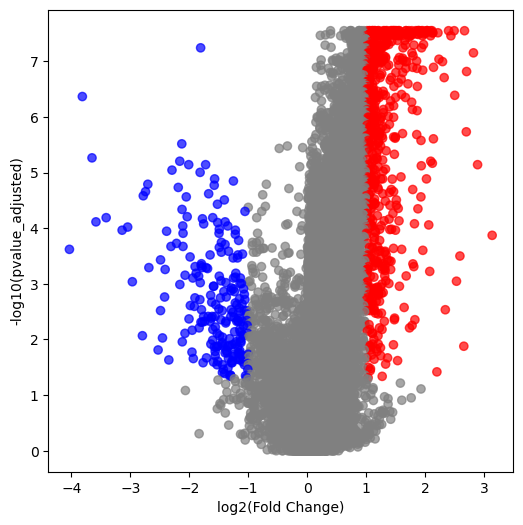

In [39]:
# Définir un seuil pour le log2 fold change et la p-value
fc_threshold = 1  # seuil de log2 fold change
pval_threshold = 0.05  # seuil de p-value

# Identification des points significatifs
diff_TCGA_LIHC_bis['color'] = 'grey'
diff_TCGA_LIHC_bis.loc[(diff_TCGA_LIHC_bis['rank'] > fc_threshold) & (diff_TCGA_LIHC_bis['pval_adj'] < pval_threshold), 'color'] = 'red'
diff_TCGA_LIHC_bis.loc[(diff_TCGA_LIHC_bis['rank'] < -fc_threshold) & (diff_TCGA_LIHC_bis['pval_adj'] < pval_threshold), 'color'] = 'blue'

# Création du volcanoplot
plt.figure(figsize=(6,6))
plt.scatter(diff_TCGA_LIHC_bis['rank'], -np.log10(diff_TCGA_LIHC_bis['pval_adj']), c=diff_TCGA_LIHC_bis['color'], alpha=0.7)


# Ajout des labels
plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(pvalue_adjusted)')
#plt.title('Volcano Plot')

# Affichage du graphique
plt.show()

In [40]:
len(diff_TCGA_LIHC_bis[(diff_TCGA_LIHC_bis['pval_adj'] < 0.05) & (diff_TCGA_LIHC_bis['rank'] < -1.)])

217

In [41]:
len(diff_TCGA_LIHC_bis[(diff_TCGA_LIHC_bis['pval_adj'] < 0.05) & (diff_TCGA_LIHC_bis['rank'] > 1.)])

615

# En utilisant gseapy : 

In [42]:
!pip install gseapy

In [43]:
# import some librairies

from gseapy.plot import gseaplot
import gseapy as gp 

In [44]:
from gseapy import Msigdb

In [14]:
msig = Msigdb()
# 
gmt = msig.get_gmt(category='h.all', dbver="2024.1.Hs")

In [56]:
#gmt

In [55]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [45]:
pre_res = gp.prerank(rnk = data_rank_TCGA_LIHC, gene_sets= 'MSigDB_Hallmark_2020', seed = 6)

2024-09-03 22:41:10,863 [WARNING] Duplicated values found in preranked stats: 11.53% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [47]:
#pre_res.results

In [48]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])
    
out_df = pd.DataFrame(out, columns=['Term','fdr','es','nes']).sort_values('fdr').reset_index(drop=True)

In [50]:
term_to_graph = out_df.iloc[0].Term
term_to_graph

'Mitotic Spindle'

In [53]:
# Récupérer le dictionnaire et supprimer la clé 'term' s'il existe
result_args = pre_res.results[term_to_graph].copy()  # Faites une copie pour ne pas modifier l'original
result_args.pop('term', None)  # Supprimer la clé 'term' si elle existe

# Appeler la fonction gseaplot
#gseaplot(pre_res.ranking, term=term_to_graph, **result_args)

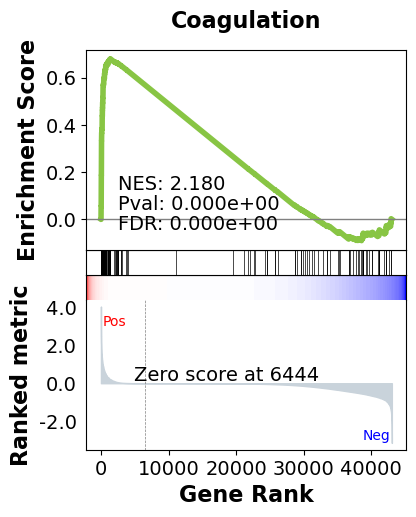

In [54]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0])

# Après avoir exécuté le logiciel GSEA

Après avoir obtenu les résultats, il faut recupérer les ensembles de gènes qui sont significatifs dans tous les datasets.

**Critères de sélection :** On prend les genes sets pour les quels la p-value (<0.05), FDR (<0.25). 

### ------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
def res(dataset1, dataset2, dataset_name):
    
    data1 = dataset1.copy()
    data2 = dataset2.copy()
    
    data1['NOM p-val'] = pd.to_numeric(data1['NOM p-val'], errors='coerce')
    data1['FDR q-val'] = pd.to_numeric(data1['FDR q-val'], errors='coerce')
    data2['NOM p-val'] = pd.to_numeric(data2['NOM p-val'], errors='coerce')
    data2['FDR q-val'] = pd.to_numeric(data2['FDR q-val'], errors='coerce')
    
    # Filtrage des dataframes en fonction des colonnes 'NOM p-val' et 'FDR q-val'
    data1 = data1[data1['NOM p-val'] < 0.05]
    data1 = data1[data1['FDR q-val'] < 0.25]
   
    data2 = data2[data2['NOM p-val'] < 0.05]
    data2 = data2[data2['FDR q-val'] < 0.25]
    
    data1 = data1[['NAME','NES']]
    data2 = data2[['NAME','NES']]
    
    # Fusionner les DataFrames
    data_final = pd.concat([data1, data2], ignore_index=True)
    # renaming
    data_final.rename(columns={'NES': dataset_name}, inplace=True)
    
    return data_final

Collection H :

In [43]:
# Lire le fichier TSV dataset TCGA-LIHC
nas_pos_TCGA_LIHC_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/TCGA_LIHC_diff_mean_H.GseaPreranked.1726674841209/gsea_report_for_na_pos_1726674841209.tsv", sep='\t')

nas_neg_TCGA_LIHC_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/TCGA_LIHC_diff_mean_H.GseaPreranked.1726674841209/gsea_report_for_na_neg_1726674841209.tsv", sep='\t')

In [44]:
nas_TCGA_LIHC_H_res = res(nas_pos_TCGA_LIHC_H,nas_neg_TCGA_LIHC_H, 'TCGA-LIHC' )
nas_TCGA_LIHC_H_res.head()

,NAME,TCGA-LIHC
0,HALLMARK_E2F_TARGETS,1.703592
1,HALLMARK_G2M_CHECKPOINT,1.611474
2,HALLMARK_MYC_TARGETS_V1,1.584315
3,HALLMARK_MITOTIC_SPINDLE,1.491103
4,HALLMARK_DNA_REPAIR,1.454311


In [45]:
# Lire le fichier TSV dataset GSE144269
nas_pos_GSE144269_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE144269_diff_mean_H.GseaPreranked.1726674960039/gsea_report_for_na_pos_1726674960039.tsv", sep='\t')

nas_neg_GSE144269_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE144269_diff_mean_H.GseaPreranked.1726674960039/gsea_report_for_na_neg_1726674960039.tsv", sep='\t')

In [46]:
nas_GSE144269_H_res = res(nas_pos_GSE144269_H, nas_neg_GSE144269_H, 'GSE144269' )
nas_GSE144269_H_res.head()

,NAME,GSE144269
0,HALLMARK_E2F_TARGETS,2.088999
1,HALLMARK_MYC_TARGETS_V1,2.034662
2,HALLMARK_G2M_CHECKPOINT,1.975971
3,HALLMARK_OXIDATIVE_PHOSPHORYLATION,1.932822
4,HALLMARK_MTORC1_SIGNALING,1.863810


In [43]:
# Lire le fichier TSV dataset GSE141202
nas_pos_GSE141202_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results/GSE141202_HCC_diff_mean.GseaPreranked.1725840546187/gsea_report_for_na_pos_1725840546187.tsv", sep='\t')

nas_neg_GSE141202_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results/GSE141202_HCC_diff_mean.GseaPreranked.1725840546187/gsea_report_for_na_neg_1725840546187.tsv", sep='\t')

In [44]:
nas_GSE141202_H_res = res(nas_pos_GSE141202_H, nas_neg_GSE141202_H, 'GSE141202' )
nas_GSE141202_H_res.head()

,NAME,GSE141202
0,HALLMARK_MYC_TARGETS_V1,-1.636401
1,HALLMARK_E2F_TARGETS,-1.609851
2,HALLMARK_MTORC1_SIGNALING,-1.585214
3,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,-1.551694
4,HALLMARK_G2M_CHECKPOINT,-1.547877


In [47]:
# Lire le fichier TSV dataset GSE76427
nas_pos_GSE76427_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE76427_diff_mean_H.GseaPreranked.1726675006567/gsea_report_for_na_pos_1726675006567.tsv", sep='\t')

nas_neg_GSE76427_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE76427_diff_mean_H.GseaPreranked.1726675006567/gsea_report_for_na_neg_1726675006567.tsv", sep='\t')

In [48]:
nas_GSE76427_H_res = res(nas_pos_GSE76427_H, nas_neg_GSE76427_H, 'GSE76427' )
nas_GSE76427_H_res.head()

,NAME,GSE76427
0,HALLMARK_E2F_TARGETS,2.777101
1,HALLMARK_G2M_CHECKPOINT,2.449604
2,HALLMARK_MYC_TARGETS_V1,2.356497
3,HALLMARK_DNA_REPAIR,1.997473
4,HALLMARK_SPERMATOGENESIS,1.874184


In [49]:
# Lire le fichier TSV dataset GSE121248
nas_pos_GSE121248_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE121248_diff_mean_H.GseaPreranked.1726675036113/gsea_report_for_na_pos_1726675036113.tsv", sep='\t')

nas_neg_GSE121248_H = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE121248_diff_mean_H.GseaPreranked.1726675036113/gsea_report_for_na_neg_1726675036113.tsv", sep='\t')

In [50]:
nas_GSE121248_H_res = res(nas_pos_GSE121248_H, nas_neg_GSE121248_H, 'GSE121248' )
nas_GSE121248_H_res.head()

,NAME,GSE121248
0,HALLMARK_E2F_TARGETS,3.201222
1,HALLMARK_G2M_CHECKPOINT,2.932459
2,HALLMARK_MYC_TARGETS_V1,2.415623
3,HALLMARK_MITOTIC_SPINDLE,2.203322
4,HALLMARK_DNA_REPAIR,2.157064


Collection C2 :

In [51]:
# Lire le fichier TSV dataset TCGA-LIHC
nas_pos_TCGA_LIHC_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/TCGA_LIHC_HCC_diff_mean.GseaPreranked.1726659069166/gsea_report_for_na_pos_1726659069166.tsv", sep='\t')

nas_neg_TCGA_LIHC_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/TCGA_LIHC_HCC_diff_mean.GseaPreranked.1726659069166/gsea_report_for_na_neg_1726659069166.tsv", sep='\t')

In [52]:
nas_pos_TCGA_LIHC_C2_res = res(nas_pos_TCGA_LIHC_C2, nas_neg_TCGA_LIHC_C2, 'TCGA-LIHC')
nas_pos_TCGA_LIHC_C2_res.head() 

,NAME,TCGA-LIHC
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466
1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304
2,CROONQUIST_NRAS_SIGNALING_DN,1.762227
3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.75229
4,ISHIDA_E2F_TARGETS,1.750866


In [53]:
# Lire le fichier TSV dataset GSE144269
nas_pos_GSE144269_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE144269_HCC_diff_mean.GseaPreranked.1726661389853/gsea_report_for_na_pos_1726661389853.tsv", sep='\t')

nas_neg_GSE144269_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE144269_HCC_diff_mean.GseaPreranked.1726661389853/gsea_report_for_na_neg_1726661389853.tsv", sep='\t')

In [54]:
nas_pos_GSE144269_C2_res = res(nas_pos_GSE144269_C2, nas_neg_GSE144269_C2, 'GSE144269')
nas_pos_GSE144269_C2_res.head() 

,NAME,GSE144269
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,2.33599
1,SOTIRIOU_BREAST_CANCER_GRADE_1_VS_3_UP,2.285709
2,CROONQUIST_IL6_DEPRIVATION_DN,2.236161
3,REACTOME_CONDENSATION_OF_PROPHASE_CHROMOSOMES,2.223801
4,RHODES_UNDIFFERENTIATED_CANCER,2.212316


In [49]:
# Lire le fichier TSV dataset GSE141202
nas_pos_GSE141202_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results/GSE141202_HCC_diff_mean.GseaPreranked.1726141067915/gsea_report_for_na_pos_1726141067915.tsv", sep='\t')

nas_neg_GSE141202_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results/GSE141202_HCC_diff_mean.GseaPreranked.1726141067915/gsea_report_for_na_neg_1726141067915.tsv", sep='\t')

In [50]:
nas_pos_GSE141202_C2_res = res(nas_pos_GSE141202_C2, nas_neg_GSE141202_C2, 'GSE141202')
nas_pos_GSE141202_C2_res.head() 

,NAME,GSE141202
0,REACTOME_CLASS_C_3_METABOTROPIC_GLUTAMATE_PHER...,2.1442573
1,REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTI...,2.1078532
2,WP_COMPLEMENT_ACTIVATION,2.080727
3,REACTOME_CHROMATIN_MODIFICATIONS_DURING_THE_MA...,2.0105026
4,REACTOME_DNA_METHYLATION,2.005907


In [55]:
# Lire le fichier TSV dataset GSE141202
nas_pos_GSE76427_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE76427_HCC_diff_mean.GseaPreranked.1726663095591/gsea_report_for_na_pos_1726663095591.tsv", sep='\t')

nas_neg_GSE76427_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE76427_HCC_diff_mean.GseaPreranked.1726663095591/gsea_report_for_na_neg_1726663095591.tsv", sep='\t')

In [56]:
nas_pos_GSE76427_C2_res = res(nas_pos_GSE76427_C2, nas_neg_GSE76427_C2, 'GSE76427')
nas_pos_GSE76427_C2_res.head() 

,NAME,GSE76427
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,2.877905
1,SOTIRIOU_BREAST_CANCER_GRADE_1_VS_3_UP,2.841638
2,FISCHER_DREAM_TARGETS,2.791857
3,BLANCO_MELO_BRONCHIAL_EPITHELIAL_CELLS_INFLUEN...,2.732366
4,PUJANA_BRCA2_PCC_NETWORK,2.720200


In [57]:
# Lire le fichier TSV dataset GSE121248
nas_pos_GSE121248_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE121248_HCC_diff_mean.GseaPreranked.1726664836309/gsea_report_for_na_pos_1726664836309.tsv", sep='\t')

nas_neg_GSE121248_C2 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE121248_HCC_diff_mean.GseaPreranked.1726664836309/gsea_report_for_na_neg_1726664836309.tsv", sep='\t')

In [58]:
nas_pos_GSE121248_C2_res = res(nas_pos_GSE121248_C2, nas_neg_GSE121248_C2, 'GSE121248')
nas_pos_GSE121248_C2_res.head() 

,NAME,GSE121248
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,3.402050
1,SOTIRIOU_BREAST_CANCER_GRADE_1_VS_3_UP,3.352886
2,KOBAYASHI_EGFR_SIGNALING_24HR_DN,3.264010
3,PATIL_LIVER_CANCER,3.260270
4,SHEDDEN_LUNG_CANCER_POOR_SURVIVAL_A6,3.243669


In [55]:
# fusionner les colonnes 

data_result = pd.merge(nas_pos_GSE76427_C2_res, nas_pos_GSE121248_C2_res, on='NAME', how='inner')
#data_result_bis = pd.merge(data_result, nas_pos_GSE144269_C2_res, on='NAME', how='inner')

data_result.head()

,NAME,GSE76427,GSE121248
0,ACEVEDO_LIVER_TUMOR_VS_NORMAL_ADJACENT_TISSUE_DN,2.801583,2.829907
1,MCLACHLAN_DENTAL_CARIES_UP,2.775304,2.910070
2,ACEVEDO_LIVER_CANCER_DN,2.730730,2.488713
3,HSIAO_LIVER_SPECIFIC_GENES,2.712410,2.535578
4,CAIRO_HEPATOBLASTOMA_DN,2.683673,2.997696


In [56]:
len(data_result)

2204

Collection C5 :

In [59]:
# Lire le fichier TSV TCGA-LIHC dataset
nas_pos_TCGA_LIHC_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/TCGA_LIHC_HCC_diff_mean_C5.GseaPreranked.1726666449582/gsea_report_for_na_pos_1726666449582.tsv", sep='\t')

nas_neg_TCGA_LIHC_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/TCGA_LIHC_HCC_diff_mean_C5.GseaPreranked.1726666449582/gsea_report_for_na_neg_1726666449582.tsv", sep='\t')

In [60]:
nas_pos_TCGA_LIHC_C5_res = res(nas_pos_TCGA_LIHC_C5, nas_neg_TCGA_LIHC_C5, 'TCGA-LIHC')
nas_pos_TCGA_LIHC_C5_res.head() 

,NAME,TCGA-LIHC
0,GOBP_ATTACHMENT_OF_SPINDLE_MICROTUBULES_TO_KIN...,1.582418
1,GOMF_SINGLE_STRANDED_DNA_HELICASE_ACTIVITY,1.581488
2,GOBP_CHROMOSOME_SEPARATION,1.571633
3,GOBP_SISTER_CHROMATID_SEGREGATION,1.568609
4,GOCC_CATALYTIC_STEP_2_SPLICEOSOME,1.565499


In [59]:
# Lire le fichier TSV GSE141202 dataset
nas_pos_GSE141202_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results/GSE141202_diff_mean.GseaPreranked.1726236449774/gsea_report_for_na_pos_1726236449774.tsv", sep='\t')

nas_neg_GSE141202_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results/GSE141202_diff_mean.GseaPreranked.1726236449774\gsea_report_for_na_neg_1726236449774.tsv", sep='\t')

In [60]:
nas_pos_GSE141202_C5_res = res(nas_pos_GSE141202_C5, nas_neg_GSE141202_C5, 'GSE141202')
nas_pos_GSE141202_C5_res.head() 

,NAME,GSE141202
0,GOMF_TASTE_RECEPTOR_ACTIVITY,2.2741582
1,GOMF_BITTER_TASTE_RECEPTOR_ACTIVITY,2.1477187
2,GOBP_DETECTION_OF_CHEMICAL_STIMULUS_INVOLVED_I...,2.1187196
3,GOCC_IGG_IMMUNOGLOBULIN_COMPLEX,2.0900571
4,GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT,2.0523894


In [61]:
# Lire le fichier TSV GSE144269 dataset
nas_pos_GSE144269_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE144269_diff_mean_C5.GseaPreranked.1726668739802/gsea_report_for_na_pos_1726668739802.tsv", sep='\t')

nas_neg_GSE144269_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE144269_diff_mean_C5.GseaPreranked.1726668739802/gsea_report_for_na_neg_1726668739802.tsv", sep='\t')

In [62]:
nas_pos_GSE144269_C5_res = res(nas_pos_GSE144269_C5, nas_neg_GSE144269_C5, 'GSE144269')
nas_pos_GSE144269_C5_res.head() 

,NAME,GSE144269
0,GOMF_STRUCTURAL_CONSTITUENT_OF_CHROMATIN,2.227379
1,GOCC_NUCLEOSOME,2.116446
2,GOCC_RIBOSOMAL_SUBUNIT,2.056219
3,GOCC_CYTOSOLIC_LARGE_RIBOSOMAL_SUBUNIT,2.028335
4,GOCC_LARGE_RIBOSOMAL_SUBUNIT,2.020161


In [65]:
# Lire le fichier TSV GSE144269 dataset
nas_pos_GSE121248_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE121248_diff_mean_C5.GseaPreranked.1726672634108/gsea_report_for_na_pos_1726672634108.tsv", sep='\t')

nas_neg_GSE121248_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE121248_diff_mean_C5.GseaPreranked.1726672634108/gsea_report_for_na_neg_1726672634108.tsv", sep='\t')

In [66]:
nas_pos_GSE121248_C5_res = res(nas_pos_GSE121248_C5, nas_neg_GSE121248_C5, 'GSE121248')
nas_pos_GSE121248_C5_res.head() 

,NAME,GSE121248
0,GOBP_CHROMOSOME_SEGREGATION,2.913310
1,GOBP_MITOTIC_SISTER_CHROMATID_SEGREGATION,2.842210
2,GOBP_NUCLEAR_CHROMOSOME_SEGREGATION,2.836416
3,GOBP_SISTER_CHROMATID_SEGREGATION,2.814713
4,GOBP_CHROMOSOME_ORGANIZATION,2.773224


In [67]:
# Lire le fichier TSV GSE144269 dataset
nas_pos_GSE76427_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE76427_diff_mean_C5.GseaPreranked.1726670555199/gsea_report_for_na_pos_1726670555199.tsv", sep='\t')

nas_neg_GSE76427_C5 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/GSEA_results_bis/GSE76427_diff_mean_C5.GseaPreranked.1726670555199/gsea_report_for_na_neg_1726670555199.tsv", sep='\t')

In [68]:
nas_pos_GSE76427_C5_res = res(nas_pos_GSE76427_C5, nas_neg_GSE76427_C5, 'GSE76427')
nas_pos_GSE76427_C5_res.head() 

,NAME,GSE76427
0,GOBP_CHROMOSOME_SEGREGATION,2.476046
1,GOCC_CHROMOSOMAL_REGION,2.448316
2,GOBP_NUCLEAR_CHROMOSOME_SEGREGATION,2.439099
3,GOCC_CONDENSED_CHROMOSOME_CENTROMERIC_REGION,2.414650
4,GOCC_CHROMOSOME_CENTROMERIC_REGION,2.412291


In [69]:
len(nas_pos_GSE121248_C5_res)

3542

In [70]:
len(nas_pos_GSE76427_C5_res)

3141

In [71]:
len(nas_pos_GSE144269_C5_res)

2861

In [73]:
#len(nas_pos_GSE141202_C5_res)

In [74]:
len(nas_pos_TCGA_LIHC_C5_res)

2466

In [75]:
len(nas_pos_GSE144269_C2_res)

2460

In [76]:
len(nas_pos_GSE76427_C2_res)

2808

In [77]:
len(nas_pos_GSE121248_C2_res)

2898

In [77]:
len(nas_pos_GSE141202_C2_res)

1577

In [78]:
len(nas_pos_TCGA_LIHC_C2_res)

2003

In [79]:
len(nas_GSE144269_H_res)

24

In [81]:
#len(nas_GSE141202_H_res)

In [82]:
len(nas_TCGA_LIHC_H_res)

18

In [83]:
len(nas_GSE76427_H_res)

37

In [84]:
len(nas_GSE121248_H_res)

38

Intersection dataset : collection C2

In [85]:
# fusionner les colonnes 

data_result1 = pd.merge(nas_pos_TCGA_LIHC_C2_res, nas_pos_GSE144269_C2_res, on='NAME', how='inner')
data_result2 = pd.merge(nas_pos_GSE121248_C2_res, nas_pos_GSE76427_C2_res, on='NAME', how='inner')

data_result_C2 = pd.merge(data_result1, data_result2, on='NAME', how='inner')

data_result_C2.head()

,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466,2.33599,3.402050,2.877905
1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304,2.236161,3.052014,2.536148
2,CROONQUIST_NRAS_SIGNALING_DN,1.762227,2.133869,2.960949,2.565662
3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.75229,2.143114,3.055266,2.534494
4,ISHIDA_E2F_TARGETS,1.750866,2.110919,2.896595,2.559383


In [86]:
len(data_result_C2)

796

Intersection dataset : collection C5

In [87]:
# fusionner les colonnes 

data_result1 = pd.merge(nas_pos_TCGA_LIHC_C5_res, nas_pos_GSE144269_C5_res, on='NAME', how='inner')
data_result2 = pd.merge(nas_pos_GSE121248_C5_res, nas_pos_GSE76427_C5_res, on='NAME', how='inner')

data_result_C5 = pd.merge(data_result1, data_result2, on='NAME', how='inner')

data_result_C5.head()

,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427
0,GOBP_ATTACHMENT_OF_SPINDLE_MICROTUBULES_TO_KIN...,1.582418,1.789527,2.511213,2.202604
1,GOMF_SINGLE_STRANDED_DNA_HELICASE_ACTIVITY,1.581488,1.869943,2.289868,1.892581
2,GOBP_CHROMOSOME_SEPARATION,1.571633,1.849625,2.755552,2.245893
3,GOBP_SISTER_CHROMATID_SEGREGATION,1.568609,1.837036,2.814713,2.392833
4,GOCC_CATALYTIC_STEP_2_SPLICEOSOME,1.565499,1.654929,2.075092,2.027117


In [88]:
len(data_result_C5)

522

Intersection dataset : collection H

In [89]:
# fusionner les colonnes 

data_result1 = pd.merge(nas_TCGA_LIHC_H_res, nas_GSE144269_H_res, on='NAME', how='inner')
data_result2 = pd.merge(nas_GSE121248_H_res, nas_GSE76427_H_res, on='NAME', how='inner')

data_result_H = pd.merge(data_result1, data_result2, on='NAME', how='inner')

data_result_H.head()

,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427
0,HALLMARK_E2F_TARGETS,1.703592,2.088999,3.201222,2.777101
1,HALLMARK_G2M_CHECKPOINT,1.611474,1.975971,2.932459,2.449604
2,HALLMARK_MYC_TARGETS_V1,1.584315,2.034662,2.415623,2.356497
3,HALLMARK_MITOTIC_SPINDLE,1.491103,1.601816,2.203322,1.866421
4,HALLMARK_DNA_REPAIR,1.454311,1.759386,2.157064,1.997473


In [90]:
len(data_result_H)

8

Concaténation : 

In [91]:
# Fusionner les DataFrames
data = pd.concat([data_result_C2, data_result_C5], ignore_index=True)
data_final_all_collection = pd.concat([data, data_result_H], ignore_index=True)

In [92]:
data_final_all_collection

,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466,2.33599,3.402050,2.877905
1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304,2.236161,3.052014,2.536148
2,CROONQUIST_NRAS_SIGNALING_DN,1.762227,2.133869,2.960949,2.565662
3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.75229,2.143114,3.055266,2.534494
4,ISHIDA_E2F_TARGETS,1.750866,2.110919,2.896595,2.559383
...,...,...,...,...,...
1321,HALLMARK_MITOTIC_SPINDLE,1.491103,1.601816,2.203322,1.866421
1322,HALLMARK_DNA_REPAIR,1.454311,1.759386,2.157064,1.997473
1323,HALLMARK_MTORC1_SIGNALING,1.403697,1.86381,1.733690,1.435655
1324,HALLMARK_SPERMATOGENESIS,1.295353,1.537753,1.978650,1.874184


In [93]:
len(data_final_all_collection)

1326

In [94]:
data_final_all_collection["TCGA-LIHC"] = data_final_all_collection["TCGA-LIHC"].astype(float)
data_final_all_collection["GSE144269"] = data_final_all_collection["GSE144269"].astype(float)
data_final_all_collection["GSE121248"] = data_final_all_collection["GSE121248"].astype(float)
data_final_all_collection["GSE76427"] = data_final_all_collection["GSE76427"].astype(float)

In [95]:
data_final_all_collection = data_final_all_collection.sort_values(by='TCGA-LIHC', ascending=False).reset_index()

In [96]:
data_final_all_collection

,index,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427
0,0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466,2.335990,3.402050,2.877905
1,1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304,2.236161,3.052014,2.536148
2,2,CROONQUIST_NRAS_SIGNALING_DN,1.762227,2.133869,2.960949,2.565662
3,3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.752290,2.143114,3.055266,2.534494
4,4,ISHIDA_E2F_TARGETS,1.750866,2.110919,2.896595,2.559383
...,...,...,...,...,...,...
1321,694,WOO_LIVER_CANCER_RECURRENCE_DN,-2.636813,-1.453834,-1.929293,-2.213385
1322,693,SU_LIVER,-2.689292,-2.268493,-2.210612,-2.375964
1323,692,DESERT_PERIPORTAL_HEPATOCELLULAR_CARCINOMA_SUB...,-2.759864,-2.914305,-2.688483,-2.161259
1324,691,ANDERSEN_LIVER_CANCER_KRT19_DN,-2.765826,-1.491596,-2.065374,-2.129793


In [97]:
data_final_all_collection = data_final_all_collection.drop('index', axis=1)

In [98]:
data_final_all_collection

,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466,2.335990,3.402050,2.877905
1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304,2.236161,3.052014,2.536148
2,CROONQUIST_NRAS_SIGNALING_DN,1.762227,2.133869,2.960949,2.565662
3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.752290,2.143114,3.055266,2.534494
4,ISHIDA_E2F_TARGETS,1.750866,2.110919,2.896595,2.559383
...,...,...,...,...,...
1321,WOO_LIVER_CANCER_RECURRENCE_DN,-2.636813,-1.453834,-1.929293,-2.213385
1322,SU_LIVER,-2.689292,-2.268493,-2.210612,-2.375964
1323,DESERT_PERIPORTAL_HEPATOCELLULAR_CARCINOMA_SUB...,-2.759864,-2.914305,-2.688483,-2.161259
1324,ANDERSEN_LIVER_CANCER_KRT19_DN,-2.765826,-1.491596,-2.065374,-2.129793


In [99]:
def pos_neg(row):
    
    for x in row[1:] :
        if x > 0 :
             return 'pos'   
        else :
            return 'neg'

data_final_all_collection['Signe(NES)'] = data_final_all_collection.apply(pos_neg, axis=1)

# 
data_final_all_collection['N'] = 4

In [100]:
data_final_all_collection

,NAME,TCGA-LIHC,GSE144269,GSE121248,GSE76427,Signe(NES),N
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466,2.335990,3.402050,2.877905,pos,4
1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304,2.236161,3.052014,2.536148,pos,4
2,CROONQUIST_NRAS_SIGNALING_DN,1.762227,2.133869,2.960949,2.565662,pos,4
3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.752290,2.143114,3.055266,2.534494,pos,4
4,ISHIDA_E2F_TARGETS,1.750866,2.110919,2.896595,2.559383,pos,4
...,...,...,...,...,...,...,...
1321,WOO_LIVER_CANCER_RECURRENCE_DN,-2.636813,-1.453834,-1.929293,-2.213385,neg,4
1322,SU_LIVER,-2.689292,-2.268493,-2.210612,-2.375964,neg,4
1323,DESERT_PERIPORTAL_HEPATOCELLULAR_CARCINOMA_SUB...,-2.759864,-2.914305,-2.688483,-2.161259,neg,4
1324,ANDERSEN_LIVER_CANCER_KRT19_DN,-2.765826,-1.491596,-2.065374,-2.129793,neg,4


In [101]:
# renaming
data_final_all_collection.rename(columns={'NAME': 'Gene set'}, inplace=True)
data_final_all_collection

,Gene set,TCGA-LIHC,GSE144269,GSE121248,GSE76427,Signe(NES),N
0,ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER,1.786466,2.335990,3.402050,2.877905,pos,4
1,CROONQUIST_IL6_DEPRIVATION_DN,1.770304,2.236161,3.052014,2.536148,pos,4
2,CROONQUIST_NRAS_SIGNALING_DN,1.762227,2.133869,2.960949,2.565662,pos,4
3,ZHAN_MULTIPLE_MYELOMA_PR_UP,1.752290,2.143114,3.055266,2.534494,pos,4
4,ISHIDA_E2F_TARGETS,1.750866,2.110919,2.896595,2.559383,pos,4
...,...,...,...,...,...,...,...
1321,WOO_LIVER_CANCER_RECURRENCE_DN,-2.636813,-1.453834,-1.929293,-2.213385,neg,4
1322,SU_LIVER,-2.689292,-2.268493,-2.210612,-2.375964,neg,4
1323,DESERT_PERIPORTAL_HEPATOCELLULAR_CARCINOMA_SUB...,-2.759864,-2.914305,-2.688483,-2.161259,neg,4
1324,ANDERSEN_LIVER_CANCER_KRT19_DN,-2.765826,-1.491596,-2.065374,-2.129793,neg,4


In [102]:
# Sauvegarder le DataFrame dans un fichier CSV

data_final_all_collection.to_csv("resultats_bis_analyse_GSEA_collection_H_C2_C5.csv", sep=';', index=False)